<a href="https://colab.research.google.com/github/tj-mas04/Breast-Cancer-Detection-with-Radiological-Images_SVM/blob/main/SVM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Set up folder paths
train_folder = '/content/drive/MyDrive/dtaet2/train'
test_folder = '/content/drive/MyDrive/dtaet2/test'
valid_folder = '/content/drive/MyDrive/dtaet2/valid'

In [ ]:
# Function to load images in grayscale from a specified folder structure
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in ['0', '1']:  # '0' for benign, '1' for malignant
        label_path = os.path.join(folder, label)

        if not os.path.exists(label_path):
            print(f"Warning: Folder {label_path} does not exist.")
            continue

        # Loop through each image file in the folder
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
                images.append(img)
                labels.append(int(label))
            else:
                print(f"Warning: Could not load image {img_path}")  # Debugging output

    return np.array(images), np.array(labels)


In [ ]:
# Load dataset (train, test, valid)
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)
X_valid, y_valid = load_images_from_folder(valid_folder)

# Normalize the pixel values (optional, helps with model convergence)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

# Flatten grayscale images (64x64) to 1D arrays (4096,)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)


In [ ]:
# Create an SVM classifier
clf = svm.SVC(kernel='linear')  # You can also try 'rbf' or 'poly' kernels

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

[[138  70]
 [ 87  41]]
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       208
           1       0.37      0.32      0.34       128

    accuracy                           0.53       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.52      0.53      0.53       336



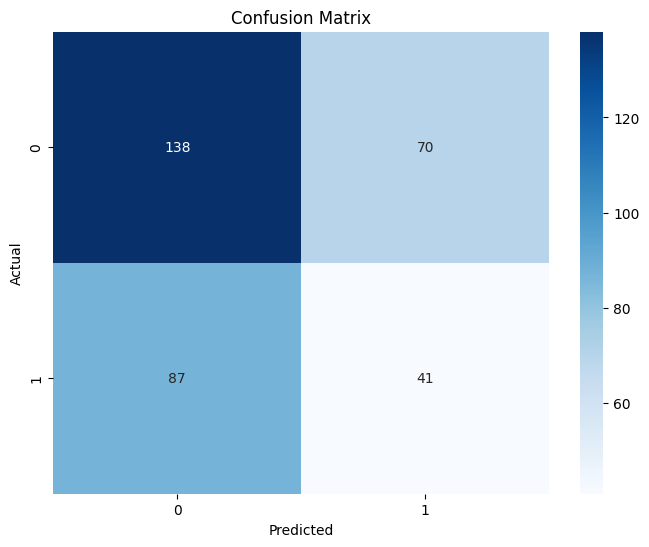

In [ ]:
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Save the model to a file
joblib.dump(clf, '/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

['/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl']

In [ ]:
# Load the model
model = joblib.load('/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return "Image not found"

    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    print("Image shape after resizing:", img.shape)  # Debugging output
    img = img.reshape(1, -1)  # Flatten the image
    prediction = model.predict(img)

    # Convert prediction to label
    label = 'Malignant' if prediction[0] == 1 else 'Benign'

    # Display the image with the label
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))  # Read in color for display
    plt.title(f'Prediction: {label}', fontsize=16)
    plt.axis('off')  # Hide axis
    plt.show()

    return label

Image shape after resizing: (64, 64)


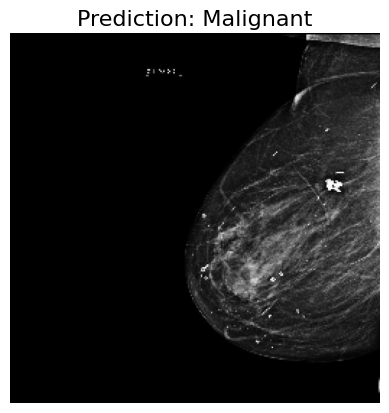

Malignant


In [ ]:
print(predict_image('/content/drive/MyDrive/dtaet2/valid/1/10130_1360338805_png.rf.2a2e24224e090892b241f613f8e8d9e6.jpg'))

#improved model 1


Confusion Matrix:
 [[138  70]
 [ 87  41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.64       208
           1       0.37      0.32      0.34       128

    accuracy                           0.53       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.52      0.53      0.53       336



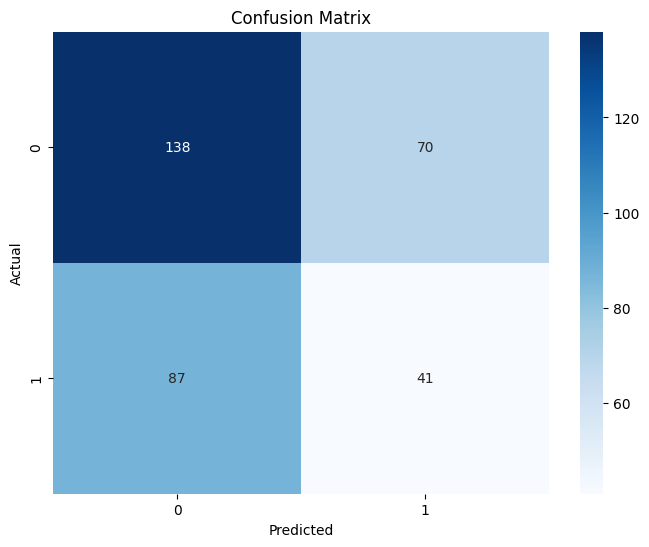

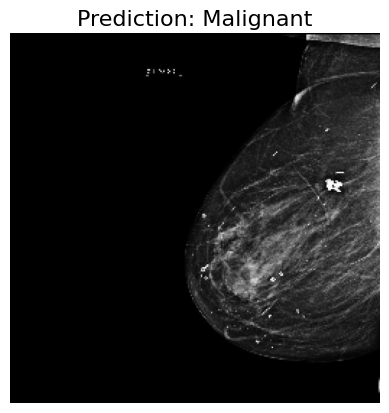

Malignant


In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from skimage.feature import hog, local_binary_pattern
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Set up folder paths
train_folder = '/content/drive/MyDrive/dtaet2/train'
test_folder = '/content/drive/MyDrive/dtaet2/test'
valid_folder = '/content/drive/MyDrive/dtaet2/valid'

# Parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract HOG, LBP, and basic pixel features from an image
def extract_features(image):
    # Resize to a standard size (e.g., 64x64)
    image_resized = cv2.resize(image, (64, 64))

    # Feature 1: Raw pixel intensities (flattened)
    pixel_features = image_resized.flatten()

    # Feature 2: HOG (Histogram of Oriented Gradients)
    hog_features = hog(image_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    # Feature 3: LBP (Local Binary Patterns)
    lbp = local_binary_pattern(image_resized, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize the histogram

    # Combine all features into one feature vector
    features = np.hstack([pixel_features, hog_features, lbp_hist])
    return features

# Function to load images and extract features
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in ['0', '1']:  # '0' for benign, '1' for malignant
        label_path = os.path.join(folder, label)

        if not os.path.exists(label_path):
            print(f"Warning: Folder {label_path} does not exist.")
            continue

        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

            if img is not None:
                features = extract_features(img)
                images.append(features)
                labels.append(int(label))
            else:
                print(f"Warning: Could not load image {img_path}")

    return np.array(images), np.array(labels)

# Load dataset (train, test, valid)
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)
X_valid, y_valid = load_images_from_folder(valid_folder)

# Normalize the pixel values (optional, helps with model convergence)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

# Create an SVM classifier with the 'linear' kernel
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Save the model to a file
joblib.dump(clf, '/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

# Load the model
model = joblib.load('/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

# Function to predict a single image
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return "Image not found"

    features = extract_features(img)  # Extract HOG + LBP + pixel features
    features = features.reshape(1, -1)  # Flatten the image for SVM input
    prediction = model.predict(features)

    # Convert prediction to label
    label = 'Malignant' if prediction[0] == 1 else 'Benign'

    # Display the image with the label
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))  # Read in color for display
    plt.title(f'Prediction: {label}', fontsize=16)
    plt.axis('off')  # Hide axis
    plt.show()

    return label

print(predict_image('/content/drive/MyDrive/dtaet2/valid/1/10130_1360338805_png.rf.2a2e24224e090892b241f613f8e8d9e6.jpg'))


In [ ]:
!pip install rarfile

In [ ]:
# Unzipping the dataset (assuming you've uploaded it to Colab)
import os
from zipfile import ZipFile
import rarfile

# Path to your dataset file (modify the path if needed)
dataset_path = '/content/Unsplit Data.rar'

# Unzip the .rar file
with rarfile.RarFile(dataset_path, 'r') as rf:
    rf.extractall('/content/dataset')

# After extraction, the images should be in /content/dataset folder


#improved Model 3

In [ ]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from skimage.feature import hog, local_binary_pattern
from matplotlib import pyplot as plt

In [ ]:
# Setup paths and dataset
data_dir = '/content/dataset/'  # Change path if necessary
IMG_SIZE = 128  # Resize images to 128x128

# Preprocess images: resize, grayscale, normalize
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    return img_normalized

def load_images(data_dir):
    images = []
    labels = []

    for label in ['benign', 'malignant']:  # Assuming subfolders for each class
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Encode labels (benign = 0, malignant = 1)
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    return images, labels_encoded

images, labels = load_images(data_dir)

In [ ]:
# HOG (Histogram of Oriented Gradients) feature extraction
def extract_hog_features(images):
    hog_features = []
    for img in images:
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feat)
    return np.array(hog_features)

hog_features = extract_hog_features(images)

In [ ]:
# SIFT (Scale-Invariant Feature Transform) feature extraction
sift = cv2.SIFT_create()

def extract_sift_features(images):
    sift_features = []
    for img in images:
        # Ensure the image is in 8-bit grayscale
        if img.dtype != 'uint8':
            img = (img * 255).astype('uint8')
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            des = np.ravel(des)[:128]  # Limiting features for simplicity
            sift_features.append(des)
        else:
            sift_features.append(np.zeros(128))  # For cases with no keypoints
    return np.array(sift_features)

sift_features = extract_sift_features(images)

In [ ]:
# LBP (Local Binary Patterns) feature extraction
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= hist.sum()  # Normalize the histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

lbp_features = extract_lbp_features(images)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
# Color Histogram (for grayscale intensity)
def extract_color_histograms(images, bins=64):
    color_hist_features = []
    for img in images:
        # Convert the image to 8-bit for histogram calculation
        if img.dtype != 'uint8':
            img_8bit = (img * 255).astype('uint8')
        else:
            img_8bit = img

        # Compute the histogram
        hist = cv2.calcHist([img_8bit], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten
        color_hist_features.append(hist)

    return np.array(color_hist_features)


color_hist_features = extract_color_histograms(images)

In [ ]:
# Concatenate all extracted features
X = np.hstack((hog_features, sift_features, lbp_features, color_hist_features))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train SVM Classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")

# Save the model
joblib.dump(svm_clf, 'svm_breast_cancer_model.pkl')

SVM Accuracy: 58.49%


['svm_breast_cancer_model.pkl']

In [ ]:
# Prediction on a new image
def predict_image(image_path, model):
    img = preprocess_image(image_path)

    # Extract features for the new image
    hog_feat = extract_hog_features([img])
    sift_feat = extract_sift_features([img])
    lbp_feat = extract_lbp_features([img])
    color_hist_feat = extract_color_histograms([img])

    # Concatenate all features
    features = np.hstack((hog_feat, sift_feat, lbp_feat, color_hist_feat))

    # Predict
    pred = model.predict(features)
    return 'Malignant' if pred[0] == 1 else 'Benign'

In [ ]:
# Load the model and make a prediction on a new image
svm_model = joblib.load('svm_breast_cancer_model.pkl')
new_image_path = '/content/drive/MyDrive/dtaet2/valid/0/115_463070125_png.rf.d5ea5a9967a7c1a8b2dea142c17ae843.jpg'  # Replace with actual image path
result = predict_image(new_image_path, svm_model)
print(f"Prediction: {result}")

Prediction: Benign


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Benign


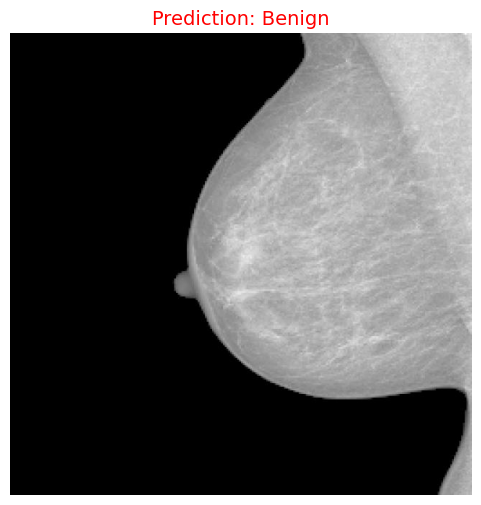

Test Accuracy: 58.49%


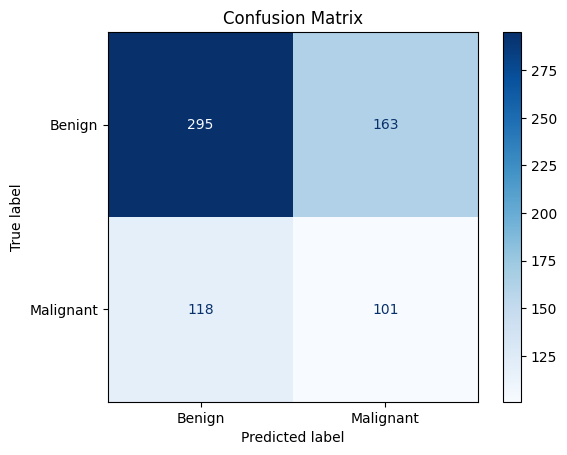

Classification Report:
               precision    recall  f1-score   support

      Benign       0.71      0.64      0.68       458
   Malignant       0.38      0.46      0.42       219

    accuracy                           0.58       677
   macro avg       0.55      0.55      0.55       677
weighted avg       0.61      0.58      0.59       677



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import cv2
import numpy as np
from sklearn.metrics import accuracy_score

# Part 1: Prediction on a new image and display with label
def predict_image(image_path, model):
    img = preprocess_image(image_path)

    # Extract features for the new image
    hog_feat = extract_hog_features([img])
    sift_feat = extract_sift_features([img])
    lbp_feat = extract_lbp_features([img])
    color_hist_feat = extract_color_histograms([img])

    # Concatenate all features
    features = np.hstack((hog_feat, sift_feat, lbp_feat, color_hist_feat))

    # Predict
    pred = model.predict(features)
    return 'Malignant' if pred[0] == 1 else 'Benign'

# Function to display the image with the predicted class
def display_image_with_label(image_path, label):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert image from BGR (OpenCV) to RGB (Matplotlib uses RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb, cmap='gray')
    plt.title(f'Prediction: {label}', fontsize=14, color='red')
    plt.axis('off')  # Hide the axis
    plt.show()

# Load the trained model
svm_model = joblib.load('svm_breast_cancer_model.pkl')

# Replace with the path to your new image
new_image_path = '/content/drive/MyDrive/dtaet2/valid/0/115_463070125_png.rf.d5ea5a9967a7c1a8b2dea142c17ae843.jpg'
result = predict_image(new_image_path, svm_model)
print(f"Prediction: {result}")

# Display the image with the predicted label
display_image_with_label(new_image_path, result)

# Part 2: Evaluate the model on the test set and display confusion matrix
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Part 3: Display classification report (precision, recall, f1-score, support)
classification_report_str = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", classification_report_str)
